<a href="https://colab.research.google.com/github/AylinNaebzadeh/Text-Classification-Using-GNN/blob/main/Apply_GNNs_on_arXiv_200_first_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Installing Libraries and Modules

In [1]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu121


In [2]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.4 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-65mxduaw
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-65mxduaw
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9068831ac637da06e4a92f7e7ef90d9814e3b450
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.5.0-py3-none-any.whl 

In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import OGB_MAG
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn.functional as F
from torch import Tensor

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Importing files from Google Drive

In [8]:
def load_csv_from_drive(file_name):
  # Mount your Google Drive to Colab
  drive.mount('/content/drive')
  # Read the csv file from the drive path
  df = pd.read_csv('/content/drive/MyDrive/' + file_name)
  # Return the dataframe
  return df

In [10]:
first_200_df = load_csv_from_drive('arXiv-dataset/df_only_first_200_with_id_v2.csv')
label_label_df = load_csv_from_drive('arXiv-dataset/corr_long_filtered_v2.csv')
doc_doc_df = load_csv_from_drive('arXiv-dataset/text_text_similarity_tf_idf_v2.csv')
doc_label_df = load_csv_from_drive('arXiv-dataset/text_label_v2.csv')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Explore data files

In [ ]:
first_200_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      196 non-null    int64  
 1   text    196 non-null    object 
 2   cs.CL   196 non-null    float64
 3   cs.CR   196 non-null    float64
 4   cs.CV   196 non-null    float64
 5   cs.CY   196 non-null    float64
 6   cs.DB   196 non-null    float64
 7   cs.ET   196 non-null    float64
 8   cs.GR   196 non-null    float64
 9   cs.GT   196 non-null    float64
 10  cs.HC   196 non-null    float64
 11  cs.IR   196 non-null    float64
 12  cs.IT   196 non-null    float64
 13  cs.LG   196 non-null    float64
 14  cs.LO   196 non-null    float64
 15  cs.MA   196 non-null    float64
 16  cs.MM   196 non-null    float64
 17  cs.NE   196 non-null    float64
 18  cs.NI   196 non-null    float64
 19  cs.RO   196 non-null    float64
 20  cs.SE   196 non-null    float64
 21  cs.SI   196 non-null    float64
 22  cs

In [ ]:
first_200_df.head()

,id,text,cs.CL,cs.CR,cs.CV,cs.CY,cs.DB,cs.ET,cs.GR,cs.GT,...,cs.LG,cs.LO,cs.MA,cs.MM,cs.NE,cs.NI,cs.RO,cs.SE,cs.SI,cs.SY
0,0,TarViS: A Unified Approach for Target-based Vi...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Triple-stream Deep Metric Learning of Great Ap...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Feedback-Gated Rectified Linear Units. Feedbac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,Multi-Agent Reinforcement Learning for Fast-Ti...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,Multi-Vehicle Trajectory Prediction at Interse...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
label_label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feature1     18 non-null     object 
 1   feature2     18 non-null     object 
 2   correlation  18 non-null     float64
 3   feature1_id  18 non-null     int64  
 4   feature2_id  18 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 848.0+ bytes


In [13]:
label_label_df

,feature1,feature2,correlation,feature1_id,feature2_id
0,cs.GT,cs.MA,0.583185,6,11
1,cs.NE,cs.IT,0.326564,13,19
2,cs.NE,cs.ET,0.326564,13,4
3,cs.IR,cs.DB,0.305776,8,3
4,cs.CV,cs.MM,0.171787,18,12
5,cs.SY,cs.RO,0.166359,20,15
6,cs.LO,cs.CL,0.151302,9,0
7,cs.SE,cs.CR,0.130744,16,10
8,cs.GR,cs.CV,0.121166,5,18
9,cs.HC,cs.RO,0.085383,7,15


In [11]:
label_label_df = label_label_df.append(pd.Series(['cs.SI', 'cs.NI', 0.05, 17, 14], index=['feature1' , 'feature2', 'correlation', 'feature1_id', 'feature2_id']), ignore_index=True)

<ipython-input-11-fab087a99ae7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_label_df = label_label_df.append(pd.Series(['cs.SI', 'cs.NI', 0.05, 17, 14], index=['feature1' , 'feature2', 'correlation', 'feature1_id', 'feature2_id']), ignore_index=True)


In [ ]:
doc_doc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Text_1_id          811 non-null    int64  
 1   Text_2_id          811 non-null    int64  
 2   tf_idf_score_0.45  811 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 19.1 KB


In [ ]:
doc_doc_df.head()

,Text_1_id,Text_2_id,tf_idf_score_0.45
0,72,131,0.713937
1,8,61,0.700002
2,8,171,0.686701
3,0,22,0.679809
4,0,37,0.671704


In [ ]:
doc_label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      303 non-null    int64 
 1   text    303 non-null    object
 2   label   303 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


In [ ]:
print(doc_label_df["label"].nunique())

21


In [ ]:
doc_label_df.head()

,id,text,label
0,5,"""No, to the Right"" -- Online Language Correcti...",cs.CL
1,6,SAIDS: A Novel Approach for Sentiment Analysis...,cs.CL
2,11,An Image captioning algorithm based on the Hyb...,cs.CL
3,17,Reasoning about Causality in Games. Causal rea...,cs.CL
4,22,All in Tokens: Unifying Output Space of Visual...,cs.CL


# Applying some changes

In [12]:
mapping = {'cs.CL': 0, 'cs.LG': 1, 'cs.CY': 2, 'cs.DB': 3, 'cs.ET': 4, 'cs.GR': 5,
           'cs.GT': 6, 'cs.HC': 7, 'cs.IR': 8, 'cs.LO': 9, 'cs.CR': 10, 'cs.MA': 11,
           'cs.MM': 12, 'cs.NE': 13, 'cs.NI': 14, 'cs.RO': 15, 'cs.SE': 16, 'cs.SI': 17,
           'cs.CV': 18, 'cs.IT': 19, 'cs.SY': 20}

In [14]:
# Apply the mapping to the label column and assign the result to a new column called 'label_int'
doc_label_df['label_id'] = doc_label_df['label'].map(mapping)

In [15]:
doc_label_df.head()

,id,text,label,label_id
0,5,"""No, to the Right"" -- Online Language Correcti...",cs.CL,0
1,6,SAIDS: A Novel Approach for Sentiment Analysis...,cs.CL,0
2,11,An Image captioning algorithm based on the Hyb...,cs.CL,0
3,17,Reasoning about Causality in Games. Causal rea...,cs.CL,0
4,22,All in Tokens: Unifying Output Space of Visual...,cs.CL,0


# Convert data to Hetero Graph

In [16]:
# Create the node feature dictionary
# Define a function to process text
def process_text(text):
  # Lowercase the text
  text = text.lower()
  # Removing punctuations
  pattern = re.compile('[%s]' % re.escape(string.punctuation))
  text = re.sub(pattern, '', text)
  # Tokenize the text
  tokens = word_tokenize(text)
  # Initialize a lemmatizer
  lemmatizer = WordNetLemmatizer()
  # Lemmatize the tokens
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  # Filter out stopwords and punctuation
  stopwords = nltk.corpus.stopwords.words('english')
  tokens = [token for token in tokens if token not in stopwords]
  # Return the tokens
  return tokens

In [17]:
# Apply the function to the text column of the doc_label_df dataframe
first_200_df['tokens'] = first_200_df['text'].apply(process_text)

In [18]:
first_200_df.head()

,id,text,cs.CL,cs.CR,cs.CV,cs.CY,cs.DB,cs.ET,cs.GR,cs.GT,...,cs.LO,cs.MA,cs.MM,cs.NE,cs.NI,cs.RO,cs.SE,cs.SI,cs.SY,tokens
0,0,TarViS: A Unified Approach for Target-based Vi...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[tarvis, unified, approach, targetbased, video..."
1,1,Triple-stream Deep Metric Learning of Great Ap...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[triplestream, deep, metric, learning, great, ..."
2,2,Feedback-Gated Rectified Linear Units. Feedbac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[feedbackgated, rectified, linear, unit, feedb..."
3,3,Multi-Agent Reinforcement Learning for Fast-Ti...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[multiagent, reinforcement, learning, fasttime..."
4,4,Multi-Vehicle Trajectory Prediction at Interse...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[multivehicle, trajectory, prediction, interse..."


In [19]:
# Create a vocabulary object using the FreqDist class
vocab = FreqDist()
for tokens in first_200_df['tokens']:
  vocab.update(tokens)

In [20]:
print(vocab)

<FreqDist with 4861 samples and 23625 outcomes>


In [21]:
# Define a function to convert tokens to indices
def tokens_to_indices(tokens):
  # Initialize an empty list of indices
  indices = []
  # Loop through the tokens
  for token in tokens:
    # Get the index of the token from the vocabulary
    index = vocab[token]
    # Append the index to the list
    indices.append(index)
  # Return the indices
  return indices

In [22]:
# Apply the function to the tokens column of the doc_label_df dataframe
first_200_df['indices'] = first_200_df['tokens'].apply(tokens_to_indices)

In [23]:
# Extract tokens and indices
tokens = first_200_df['tokens'].tolist()
indices = first_200_df['indices'].tolist()

# Determine the maximum token sequence length
max_seq_length = max(len(seq) for seq in tokens)

# Initialize an empty array for node features
num_papers = len(tokens)
num_features = max_seq_length  # Each token is a feature

# Create a matrix for node features (using indices as features)
node_features = np.zeros((num_papers, num_features), dtype=int)

# Fill in the matrix with token indices
for i, seq in enumerate(tokens):
    node_features[i, :len(seq)] = indices[i]

In [ ]:
len(node_features)

196

In [ ]:
first_200_df.head()

,id,text,cs.CL,cs.CR,cs.CV,cs.CY,cs.DB,cs.ET,cs.GR,cs.GT,...,cs.MA,cs.MM,cs.NE,cs.NI,cs.RO,cs.SE,cs.SI,cs.SY,tokens,indices
0,0,TarViS: A Unified Approach for Target-based Vi...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[tarvis, unified, approach, targetbased, video...","[4, 13, 123, 1, 24, 17, 19, 44, 24, 17, 3, 2, ..."
1,1,Triple-stream Deep Metric Learning of Great Ap...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[triplestream, deep, metric, learning, great, ...","[1, 69, 26, 328, 10, 4, 4, 39, 81, 48, 26, 328..."
2,2,Feedback-Gated Rectified Linear Units. Feedbac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[feedbackgated, rectified, linear, unit, feedb...","[1, 2, 25, 5, 7, 4, 9, 1, 11, 58, 7, 6, 15, 19..."
3,3,Multi-Agent Reinforcement Learning for Fast-Ti...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[multiagent, reinforcement, learning, fasttime...","[14, 62, 328, 1, 13, 8, 4, 3, 3, 17, 22, 2, 6,..."
4,4,Multi-Vehicle Trajectory Prediction at Interse...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[multivehicle, trajectory, prediction, interse...","[1, 24, 83, 8, 115, 59, 2, 84, 15, 123, 83, 27..."


In [24]:
first_200_df['indices']

0      [4, 13, 123, 1, 24, 17, 19, 44, 24, 17, 3, 2, ...
1      [1, 69, 26, 328, 10, 4, 4, 39, 81, 48, 26, 328...
2      [1, 2, 25, 5, 7, 4, 9, 1, 11, 58, 7, 6, 15, 19...
3      [14, 62, 328, 1, 13, 8, 4, 3, 3, 17, 22, 2, 6,...
4      [1, 24, 83, 8, 115, 59, 2, 84, 15, 123, 83, 27...
                             ...                        
191    [2, 9, 62, 328, 19, 62, 328, 97, 16, 2, 24, 11...
192    [4, 5, 3, 2, 37, 19, 147, 28, 3, 86, 328, 2, 3...
193    [8, 5, 4, 35, 101, 2, 101, 26, 3, 39, 39, 10, ...
194    [19, 59, 1, 1, 78, 9, 21, 5, 29, 30, 78, 84, 1...
195    [24, 26, 20, 275, 7, 63, 6, 10, 79, 4, 63, 6, ...
Name: indices, Length: 196, dtype: object

In [25]:
# Create the HeteroData object
data = HeteroData()

In [26]:
# Save node indices:
data["label"].node_id = torch.arange(doc_label_df["label"].nunique())
data["paper"].node_id = torch.arange(doc_label_df['id'].nunique())

In [27]:

# Add node features
data['paper'].x = torch.tensor(node_features, dtype=torch.float)  # Convert to PyTorch tensor

In [28]:
# Add edges
# Assuming the dataframes contain 'source' and 'target' columns for edges
data['paper', 'similar', 'paper'].edge_index = torch.tensor(doc_doc_df[['Text_1_id', 'Text_2_id']].values).t().contiguous()
data['label', 'correlates', 'label'].edge_index = torch.tensor(label_label_df[['feature1_id' , 'feature2_id']].values).t().contiguous()
data['paper', 'has', 'label'].edge_index = torch.tensor(doc_label_df[['id', 'label_id']].values).t().contiguous()

In [29]:
data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 811] },
  (label, correlates, label)={ edge_index=[2, 18] },
  (paper, has, label)={ edge_index=[2, 303] }
)

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

In [34]:
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

In [35]:
data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 1622] },
  (label, correlates, label)={ edge_index=[2, 36] },
  (paper, has, label)={ edge_index=[2, 303] },
  (label, rev_has, paper)={ edge_index=[2, 303] }
)

In [36]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:



# Create the transform
_transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("paper", "has", "label"),
    rev_edge_types=("label", "rev_has", "paper"),
)
train_data, val_data, test_data = _transform(data)



In [37]:
train_data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 1622] },
  (label, correlates, label)={ edge_index=[2, 36] },
  (paper, has, label)={
    edge_index=[2, 171],
    edge_label=[72],
    edge_label_index=[2, 72],
  },
  (label, rev_has, paper)={ edge_index=[2, 171] }
)

In [ ]:
val_data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 1622] },
  (label, correlates, label)={ edge_index=[2, 36] },
  (paper, has, label)={
    edge_index=[2, 243],
    edge_label=[90],
    edge_label_index=[2, 90],
  },
  (label, rev_has, paper)={ edge_index=[2, 243] }
)

In [ ]:
test_data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 1622] },
  (label, correlates, label)={ edge_index=[2, 36] },
  (paper, has, label)={
    edge_index=[2, 273],
    edge_label=[90],
    edge_label_index=[2, 90],
  },
  (label, rev_has, paper)={ edge_index=[2, 273] }
)

In [38]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["paper", "has", "label"].edge_label_index
edge_label = train_data["paper", "has", "label"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[10, 5],
    neg_sampling_ratio=2.0,
    edge_label_index=(("paper", "has", "label"), edge_label_index),
    edge_label=edge_label,
    batch_size=10,
    shuffle=True,
)

# GCN Model

In [ ]:
data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 1622] },
  (label, correlates, label)={ edge_index=[2, 36] },
  (paper, has, label)={ edge_index=[2, 303] },
  (label, rev_has, paper)={ edge_index=[2, 303] }
)

In [39]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_paper: Tensor, x_label: Tensor, edge_label_index: Tensor) -> Tensor:
        # print(f"The edge label index is: {edge_label_index}")
        # Convert node embeddings to edge-level representations:
        edge_feat_label = x_label[edge_label_index[0]]
        edge_feat_paper = x_paper[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_paper * edge_feat_label).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.paper_lin = torch.nn.Linear(209, hidden_channels)
        self.label_emb = torch.nn.Embedding(data["label"].num_nodes, hidden_channels)
        self.paper_emb = torch.nn.Embedding(data["paper"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "label": self.label_emb(data["label"].node_id),
          "paper": self.paper_lin(data["paper"].x) + self.paper_emb(data["paper"].node_id),
        }
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["label"],
            x_dict["paper"],
            data["paper", "has", "label"].edge_label_index,
        )
        return pred

model = Model(hidden_channels=16)

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [40]:
import tqdm
import torch.nn.functional as F

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)

Device: 'cpu'


100%|██████████| 8/8 [00:00<00:00, 40.59it/s]


Epoch: 001, Loss: 317.8087


100%|██████████| 8/8 [00:00<00:00, 84.05it/s]


Epoch: 002, Loss: 85.9031


100%|██████████| 8/8 [00:00<00:00, 92.96it/s]


Epoch: 003, Loss: 48.3731


100%|██████████| 8/8 [00:00<00:00, 91.88it/s]


Epoch: 004, Loss: 32.2953


100%|██████████| 8/8 [00:00<00:00, 81.92it/s]


Epoch: 005, Loss: 28.5721


100%|██████████| 8/8 [00:00<00:00, 83.45it/s]


Epoch: 006, Loss: 21.9734


100%|██████████| 8/8 [00:00<00:00, 87.32it/s]

Epoch: 007, Loss: 13.2440

100%|██████████| 8/8 [00:00<00:00, 87.64it/s]


Epoch: 008, Loss: 15.0644


100%|██████████| 8/8 [00:00<00:00, 97.11it/s]


Epoch: 009, Loss: 12.3274


100%|██████████| 8/8 [00:00<00:00, 92.57it/s]


Epoch: 010, Loss: 11.4623


100%|██████████| 8/8 [00:00<00:00, 90.47it/s]


Epoch: 011, Loss: 11.9112


100%|██████████| 8/8 [00:00<00:00, 89.63it/s]


Epoch: 012, Loss: 8.8384


100%|██████████| 8/8 [00:00<00:00, 86.29it/s]


Epoch: 013, Loss: 6.9673


100%|██████████| 8/8 [00:00<00:00, 90.37it/s]


Epoch: 014, Loss: 5.5154


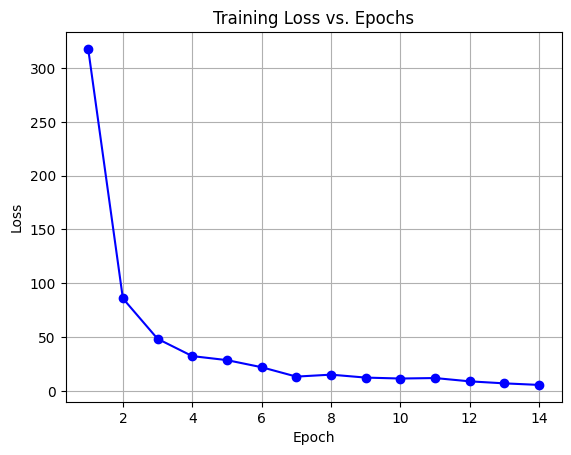

In [42]:
import matplotlib.pyplot as plt
loss_values = []
epochs = range(1, 15)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in epochs:
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        # print(f"The sampled data is: {sampled_data}")
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["paper", "has", "label"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    # Calculate average loss for the epoch
    avg_loss = total_loss / total_examples
    loss_values.append(avg_loss)  # Append to the list
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

# Create a simple plot
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.grid(True)
plt.show()

In [ ]:
val_data

HeteroData(
  label={ node_id=[21] },
  paper={
    node_id=[196],
    x=[196, 209],
  },
  (paper, similar, paper)={ edge_index=[2, 1622] },
  (label, correlates, label)={ edge_index=[2, 36] },
  (paper, has, label)={
    edge_index=[2, 243],
    edge_label=[90],
    edge_label_index=[2, 90],
  },
  (label, rev_has, paper)={ edge_index=[2, 243] }
)

In [43]:
# Define the validation seed edges:
edge_label_index = val_data["paper", "has", "label"].edge_label_index
edge_label = val_data["paper", "has", "label"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[10, 5],
    edge_label_index=(("paper", "has", "label"), edge_label_index),
    edge_label=edge_label,
    batch_size=3,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

In [51]:
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["paper", "has", "label"].edge_label)
val_pred = torch.cat(preds, dim=0).cpu().numpy()
val_ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
val_auc = roc_auc_score(val_ground_truth, val_pred)
print()
print(f"Validation AUC: {val_auc:.4f}")

100%|██████████| 30/30 [00:00<00:00, 74.87it/s]



Validation AUC: 0.7483


In [49]:
from sklearn.metrics import roc_curve, auc

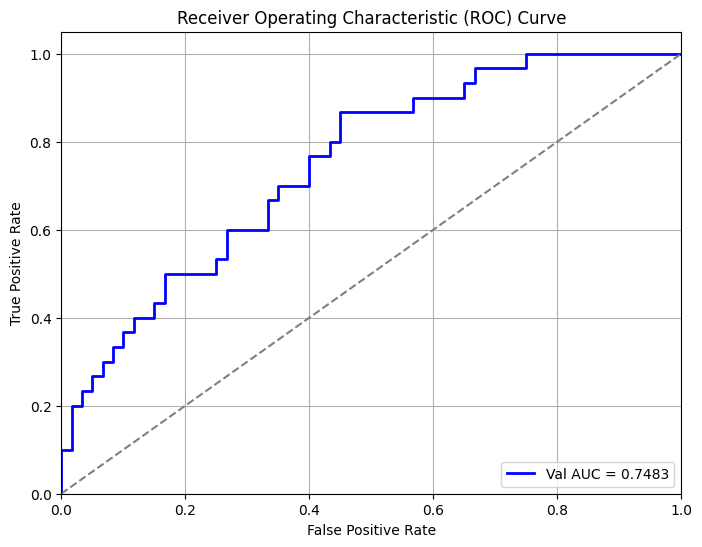

In [58]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(val_ground_truth, val_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'Val AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [53]:
# Define the validation seed edges:
edge_label_index = test_data["paper", "has", "label"].edge_label_index
edge_label = test_data["paper", "has", "label"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[10, 5],
    edge_label_index=(("paper", "has", "label"), edge_label_index),
    edge_label=edge_label,
    batch_size=3,
    shuffle=False,
)
sampled_data = next(iter(test_loader))

In [55]:
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["paper", "has", "label"].edge_label)
test_pred = torch.cat(preds, dim=0).cpu().numpy()
test_ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
test_auc = roc_auc_score(test_ground_truth, test_pred)
print()
print(f"Test test_auc: {test_auc:.4f}")

100%|██████████| 30/30 [00:00<00:00, 42.06it/s]


Test test_auc: 0.7567


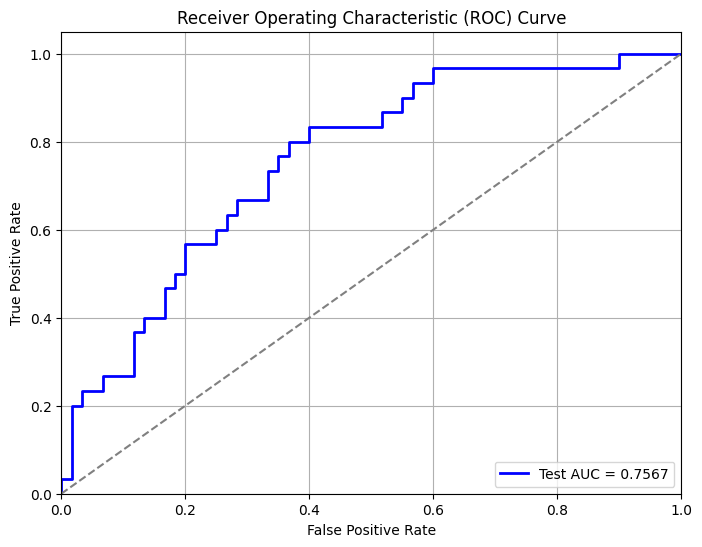

In [59]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(test_ground_truth, test_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'Test AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support

In [60]:
binary_predictions = (pred > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(val_ground_truth, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision, recall, F1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth, binary_predictions, average="macro"
)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Confusion Matrix:
[[50 10]
 [19 11]]
Precision: 0.6242
Recall: 0.6000
F1-score: 0.6033


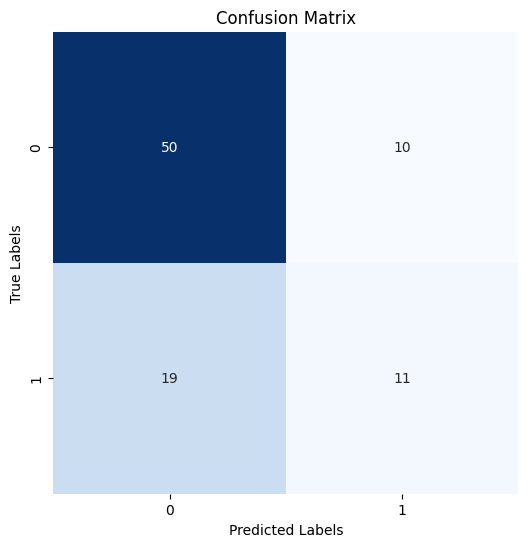

In [61]:
import seaborn as sns

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classic Models